# PASA Proyecto 1

Eliminación de ruido de EOG y EMG

In [1]:
# Para instalar en el entorno la librería para RW de archivos .edf
!pip install pyedflib
!pip install padasip

In [365]:
import mne
from __future__ import division
from mne.datasets import sample

## Carga de Datos

Probablemente haya que usar otra base de datos porque esta tiene pasabajos en 30Hz, y no se va a ver nada importante me parece

In [2]:
# Usar este comando cambiando el final del link para descargar archivos individuales
# El database completo pesa 40.1 GB y va a estar todo el día
! wget -r -N -c -np https://physionet.org/files/capslpdb/1.0.0/n1.edf

--2022-10-22 18:20:33--  https://physionet.org/files/capslpdb/1.0.0/n1.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [576]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('slp01a.dat')

OSError: slp01a.dat: the file is not EDF(+) or BDF(+) compliant (it contains format errors)

In [588]:
from pyedflib import highlevel
signals_HA, signal_headers_HA, header_HA = highlevel.read_edf('SN001.edf')

In [460]:
for i,v in signal_headers[0].items():
  print(i,':',v)

label : ROC-LOC
dimension : uV
sample_rate : 512.0
sample_frequency : 512.0
physical_max : 66.67
physical_min : -66.67
digital_max : 2184
digital_min : -2184
prefilter : LP:30.00Hz HP:0.30Hz NOTCH:50
transducer : EEG ROC-LOC


In [292]:
for i,v in header.items():
  print(i,':',v)

technician : 
recording_additional : 
patientname : 
patient_additional : 
patientcode : 
equipment : 
admincode : 
gender : 
startdate : 2009-01-01 22:06:03
birthdate : 
annotations : []


In [589]:
print('Lista de Canales en esta base de datos: \n')
for sh in signal_headers_HA:
  print(sh['label'], '  \t' ,sh['prefilter'],'  \tSample Rate:',sh['sample_rate'])

Lista de Canales en esta base de datos: 

EEG F4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG O2-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C3-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EMG chin   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0
EOG E1-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EOG E2-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
ECG   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0


La CAP Sleep Database es una colección de 108 grabaciones de Polysomniogramas del Sleep Disorders Center de Ospedale Maggiore de Parma, Italia.

Se usarán los siguientes canales para la eliminación de ruido de EEG por EOG o EMG:

- **ROC - LOC** corresponde al canal EOG de medición diferencial entre los transductores oculares derechos e izquierdos.
- **EMG1-EMG2** corresponde al canal EMG de medición diferencial entre los transductores en el músculo submental (debajo del mentón).
- **X# - Y#** corresponden a canales de EEG X# en referencia a Y#

Según los papers analizados,  el componente de mayor energia de un ECG esta alrededor de los 15Hz, el componente de los EOG alrededor de los 0.5Hz y 

In [294]:
import padasip as pa
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [590]:
#Haaglanden
fs_HA = 256
s = 1000

eeg1_HA = signals_HA[2][:s*fs]
eeg2_HA = signals_HA[3][:s*fs]
emg_HA = signals_HA[4][:s*fs]
eog1_HA = signals_HA[5][:s*fs]
eog2_HA = signals_HA[6][:s*fs]
ecg_HA = signals_HA[7][:s*fs]

eog_HA=eog1_HA-eog2_HA
#eog=signal.resample_poly(eog, 20, 5)

T = eeg.size/fs
t_HA = np.arange(0, s, step=1/fs)

In [566]:
#CAPS
fs = 512
fs_emg=256
s = 1000

eeg1 = signals[2][2*fs:(s+2)*fs]
eeg2 = signals[3][2*fs:(s+2)*fs]
emg = signals[11][2*fs_emg:(s+2)*fs_emg]
eog = signals[1][2*fs:(s+2)*fs]
ecg = signals[12][2*fs:(s+2)*fs]


emg=signal.resample(emg,fs*s)

T = eeg.size/fs
t = np.arange(0, s, step=1/fs)
print(t.shape)
print(signals[2].shape)

(512000,)
(17725440,)


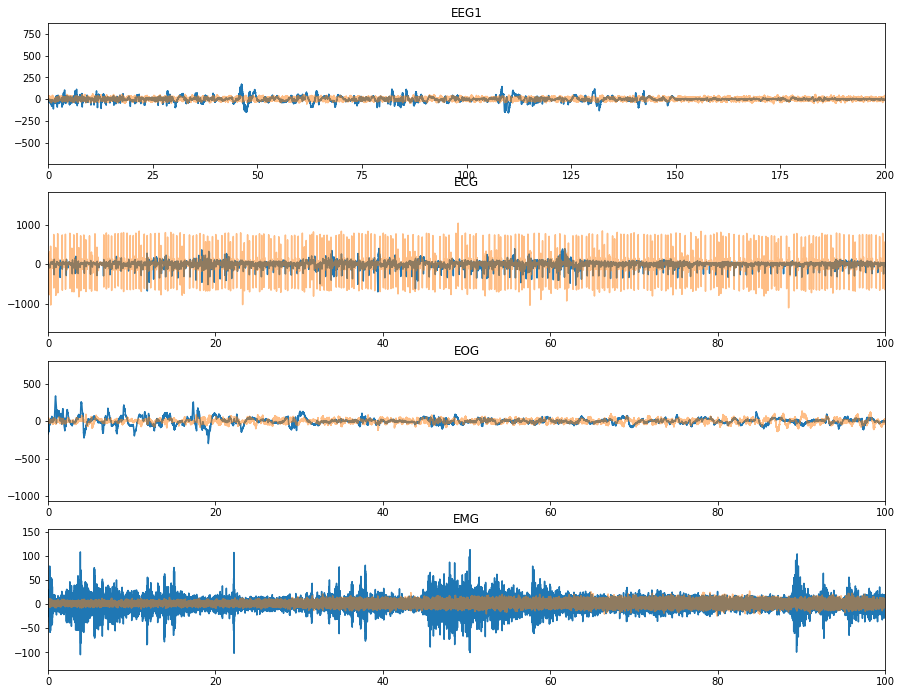

In [591]:
plt.figure(1).set_size_inches(15,15)
plt.subplot(511), plt.plot(t,eeg1), plt.xlim((0,200)), plt.title('EEG1'), plt.plot(t_HA,eeg1_HA,alpha=0.5)
plt.subplot(512), plt.plot(t,ecg), plt.xlim((0,100)), plt.title('ECG'), plt.plot(t_HA,ecg_HA,alpha=0.5)
plt.subplot(513), plt.plot(t,eog), plt.xlim((0,100)), plt.title('EOG'), plt.plot(t_HA,eog_HA,alpha=0.5)
plt.subplot(514), plt.plot(t,emg), plt.xlim((0,100)), plt.title('EMG'), plt.plot(t_HA,emg_HA,alpha=0.5)

plt.show()

In [592]:
eeg_sg_f, eeg_sg_t, eeg_sxx = signal.spectrogram(eeg,fs)
eog_sg_f, eog_sg_t, eog_sxx = signal.spectrogram(eog,fs)
emg_sg_f, emg_sg_t, emg_sxx = signal.spectrogram(emg,fs)

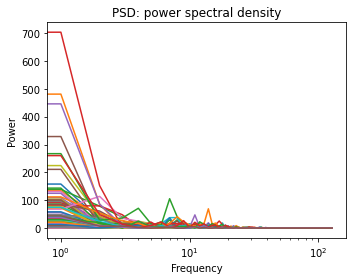

In [283]:
plt.figure(figsize=(5, 4))
plt.semilogx(eeg_sg_f, eeg_sxx)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [593]:
eog_f, eog_psd = signal.welch(eog, fs=fs, window='bartlett', nfft=256)
eeg_f, eeg_psd = signal.welch(eeg1, fs=fs, window='bartlett', nfft=256)
emg_f, emg_psd = signal.welch(emg, fs=fs, window='bartlett', nfft=256)

eog_f_HA, eog_psd_HA = signal.welch(eog_HA, fs=fs, window='bartlett', nfft=256)
eeg_f_HA, eeg_psd_HA = signal.welch(eeg1_HA, fs=fs, window='bartlett', nfft=256)
emg_f_HA, emg_psd_HA = signal.welch(emg_HA, fs=fs, window='bartlett', nfft=256)

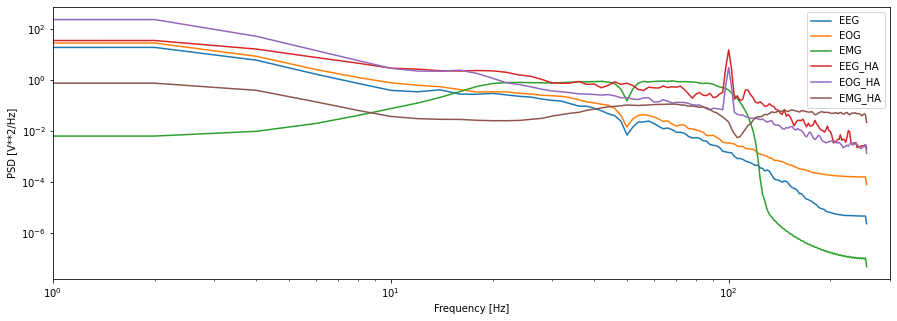

In [594]:
plt.figure(3).set_size_inches(15,5)

plt.loglog(eeg_f, eeg_psd, eog_f, eog_psd, emg_f, emg_psd)
#plt.legend(['EEG','EOG','EMG'])

plt.loglog(eeg_f_HA, eeg_psd_HA, eog_f_HA, eog_psd_HA, emg_f_HA, emg_psd_HA)
plt.legend(['EEG','EOG','EMG','EEG_HA','EOG_HA','EMG_HA'])

plt.xlabel('Frequency [Hz]')
plt.xlim([1,300])

plt.ylabel('PSD [V**2/Hz]')
plt.show()


Hay que aplicar un notch a las señales del dataset ya que se puede apreciar con claridad la presencia del ruido línea en 50Hz y de su primer armónico con  gran potencia.

In [582]:
notch1_freq=50
notch2_freq=100
Q=40

# Design a notch filter using signal.iirnotch
b_notch1, a_notch1 = signal.iirnotch(notch1_freq, Q, fs)
b_notch2, a_notch2 = signal.iirnotch(notch2_freq, Q, fs)
 
# Compute magnitude response of the designed filter
freq1, h1 = signal.freqz(b_notch1, a_notch1, fs=2*np.pi)
freq2, h2 = signal.freqz(b_notch2, a_notch2, fs=2*np.pi)

# Apply notch filter to the noisy signal using signal.filtfilt
filtered50hz_eeg_1 = signal.filtfilt(b_notch1, a_notch1, eeg1)
filtered100hz_eeg_1 = signal.filtfilt(b_notch2, a_notch2, filtered50hz_eeg_1)

filtered50hz_eeg_2 = signal.filtfilt(b_notch1, a_notch1, eeg2)
filtered100hz_eeg_2 = signal.filtfilt(b_notch2, a_notch2, filtered50hz_eeg_2)

filtered50hz_emg = signal.filtfilt(b_notch1, a_notch1, emg)
filtered100hz_emg = signal.filtfilt(b_notch2, a_notch2, filtered50hz_emg)

filtered50hz_eog = signal.filtfilt(b_notch1, a_notch1, eog)
filtered100hz_eog = signal.filtfilt(b_notch2, a_notch2, filtered50hz_eog)

filtered50hz_ecg = signal.filtfilt(b_notch1, a_notch1, ecg)
filtered100hz_ecg = signal.filtfilt(b_notch2, a_notch2, filtered50hz_ecg)

eegfiltr_f, eegfiltr_psd = signal.welch(filtered100hz_eeg_1, fs=fs, window='bartlett', nfft=256)
eeg2filtr_f, eeg2filtr_psd = signal.welch(filtered100hz_eeg_2, fs=fs, window='bartlett', nfft=256)
emgfiltr_f, emgfiltr_psd = signal.welch(filtered100hz_emg, fs=fs, window='bartlett', nfft=256)
eogfiltr_f, eogfiltr_psd = signal.welch(filtered100hz_eog, fs=fs, window='bartlett', nfft=256)
ecgfiltr_f, ecgfiltr_psd = signal.welch(filtered100hz_ecg, fs=fs, window='bartlett', nfft=256)

In [344]:
eeg1 = signals[0][:s*fs]
eeg2 = signals[3][:s*fs]
emg = signals[4][:s*fs]
eog1 = signals[5][:s*fs]
eog2 = signals[6][:s*fs]
ecg = signals[7][:s*fs]

In [345]:
notch1_freq=50
Q=40

# Design a notch filter using signal.iirnotch
b_notch1, a_notch1 = signal.iirnotch(notch1_freq, Q, fs)

 
# Compute magnitude response of the designed filter
freq1, h1 = signal.freqz(b_notch1, a_notch1, fs=2*np.pi)

# Apply notch filter to the noisy signal using signal.filtfilt
filtered50hz_eeg_1 = signal.filtfilt(b_notch1, a_notch1, eeg1)


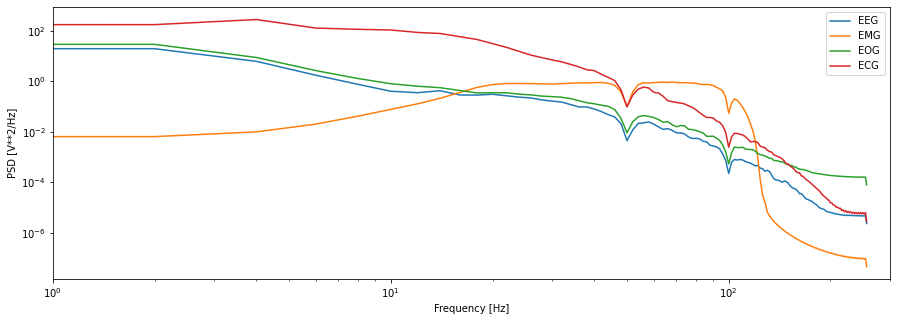

In [595]:
plt.figure(4).set_size_inches(15,5)

plt.loglog(eegfiltr_f, eegfiltr_psd, emgfiltr_f, emgfiltr_psd,eogfiltr_f, eogfiltr_psd,ecgfiltr_f, ecgfiltr_psd)
plt.legend(['EEG','EMG','EOG', 'ECG'])

plt.xlabel('Frequency [Hz]')
plt.xlim([1,300])

plt.ylabel('PSD [V**2/Hz]')
plt.show()

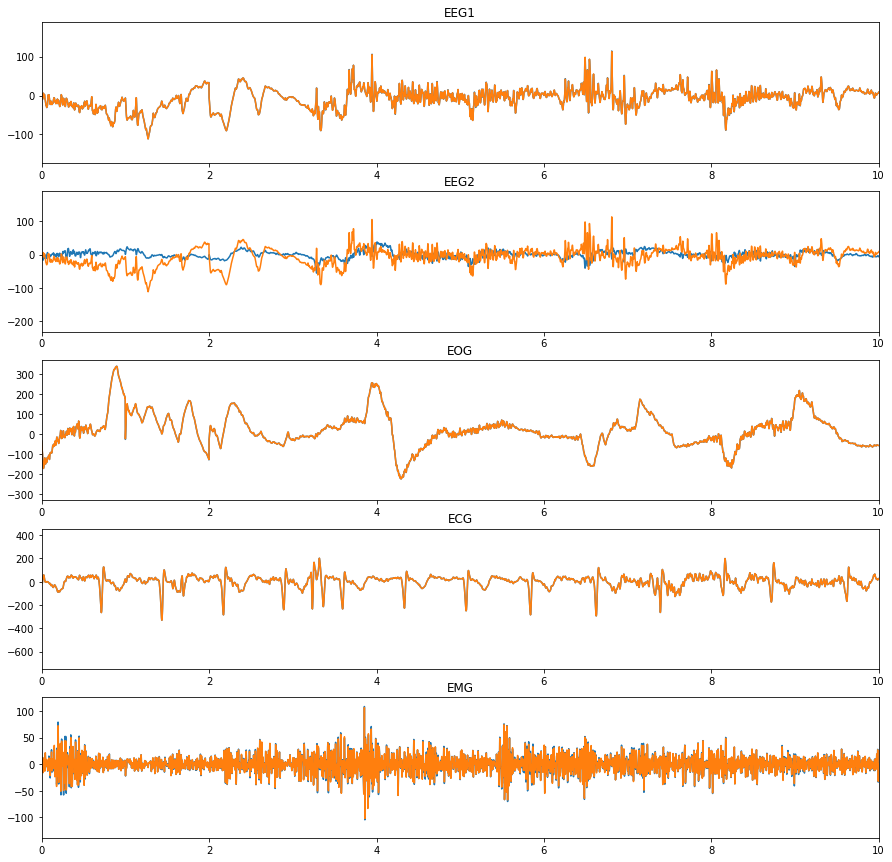

In [596]:
plt.figure(1).set_size_inches(15,15)
plt.subplot(511), plt.plot(t,eeg1), plt.plot(t,filtered100hz_eeg_1), plt.xlim((0,10)), plt.title('EEG1')
plt.subplot(512), plt.plot(t,eeg2), plt.plot(t,filtered100hz_eeg_1), plt.xlim((0,10)), plt.title('EEG2') 
plt.subplot(513), plt.plot(t,eog), plt.plot(t,filtered100hz_eog), plt.xlim((0,10)), plt.title('EOG')
plt.subplot(514), plt.plot(t,ecg), plt.plot(t,filtered100hz_ecg), plt.xlim((0,10)), plt.title('ECG')
plt.subplot(515), plt.plot(t,emg), plt.plot(t,filtered100hz_emg), plt.xlim((0,10)), plt.title('EMG')
plt.show()

## Procesamiento de Datos
- Implementar LMS
  - Input: y,x
  - Output: y_est, err
  - MetaParam: n, u, w_inicial
- Implementar PCA
  - Input: y,x
  - Output: y_est, err
  - MetaParam: n, u, w_inicial

In [14]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import progressbar as pb

## Funciones Auxiliares

In [26]:
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

In [41]:
x=np.array([1, 2, 3, 4, 5, 6])
y=data_tap(eog,4)
#y[:,0]
print(y.size)

40960


In [17]:
def tap(x, n, M):
  '''
  x: serie de datos de entrada
  n: posición de muestra más reciente
  M: cantidad de muestras
  Return
  x_tap{Mx1}: vector columna de taps con zero padding
  '''
  x_tap = np.zeros(M)

  if n<M:
    x_tap[:n+1] = x[:n+1][::-1]
  else:
    x_tap = x[n-M+1:n+1][::-1]

  x_tap = np.matrix(x_tap).T
  return x_tap

In [18]:
def lms(x, y, w0, M, mu):
  '''
  x{N}: vector (lista) datos de entrada
  y{N}: vector (lista) datos de salida
  w0{Mx1}: Estado inicial del filtro
  M: número de taps
  mu: tamaño de step

  Returns
  w: parámetros del filtro
  J: valores función de costo
  '''

  #x_n,y = data_tap(x, y, M)
  
  N = y.size

  y = y.reshape(1,N)
  w = np.matrix(np.zeros((M,N)))  # M parámetros, N instantes
  J = np.matrix(np.zeros((1,N)))  # J escalar, N instantes
  E = np.matrix(np.zeros((1,N)))  # error escalar, N instantes
  w[:,0] = w0

  progress = pb.ProgressBar(maxval = N).start()
  # Iteraciones paso a paso
  for n in range(1,N):
    
    # Taps instantáneos
    x_M = tap(x, n, M)                # Obtengo x_M(n) = [ x(n) x(n-1) ... x(n-M+1)]
    y_est = w[:,n-1].H * x_M          # Calculo y^(n)= w(n-1)^H * x_M(n)
    e = y[:,n] - y_est                # Calculo e(n) = y(n) - y^(n)
    E[:,n-1] = e                      # Guardo e(n)
    J[:,n-1] = e*e                    # Calculo J(n)
    w[:,n] = w[:,n-1] + mu * x_M * e  # Calculo w(n) = w(n-1) + mu*x_M(n)*e(n)
    # print(w[:,n-1].T) # Debugging

    '''
    y_est = w[:,n-1].H*x[:,n-1]
    e = y[:,n] - y_est
    E[:,n-1] = e
    J[:,n-1] = e*e
    w[:,n] = w[:,n-1] + mu * x[:,n-1] * e
    '''
    progress.update(n+1)
  J[:,N-1] = J[:,N-2]
  progress.update(N)
  return w, np.ravel(J), np.ravel(E)

In [19]:
def lms_montecarlo(K, w0, M, mu, N):
  w_monte = np.zeros((M,N))
  J_monte = np.zeros(N)

  progress = pb.ProgressBar(maxval = K).start()
  for i in range(K):
    # Generar señales
    x = np.random.rand(N)
    y = signal.lfilter([1,2,3],[1], x)

    w,J,e = lms(x, y, w0, M, mu)  # Algoritmo LMS

    w_monte += w
    J_monte += J
    progress.update(i+1)

  w_monte /= K
  J_monte /= K

  return w_monte, J_monte

## Análisis

### Bloque de prueba de implementación de LMS

In [21]:
N = 5120
#x = np.random.rand(N)
t = np.arange(N)
s = np.sin(2*np.pi*t/1000)
v = 0.2*np.random.rand(N)

x = s+v

y = signal.lfilter([.5,.25,.5],[1], x)

M = 3
mu = 0.0001
w0 = np.matrix(np.zeros((M,1)))
w, J, e = lms(x, y, w0, M, mu)

In [22]:
w[:,-1]

matrix([[0.2248355 ],
        [0.22439923],
        [0.22474252]])

Parametros a utlizar 


M=128
mu=0.001

### Análisis posta

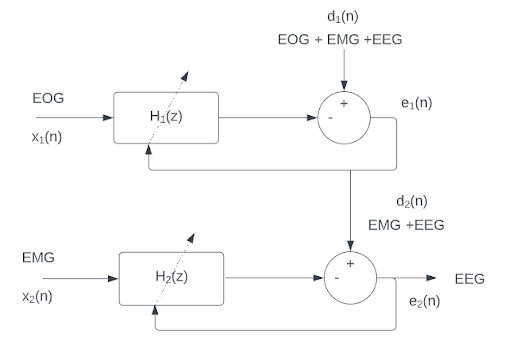

In [599]:
#parametros
M=128 
mu=.000001
mu = 0.000001
import padasip as pa

In [618]:
#Iterando ando
M=128 

mu = 0.0000001
import padasip as pa
fs_HA = 256
s = 1000

N = fs*s
t = np.arange(N)
#M = 10000

x1 = eog_HA                 # Reference Data: EOG
x1_M = data_tap(x1, M)
d1 = eeg1_HA                 # Primary EEG
print(x1_M.shape)
f1 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros')
y1, e1, w1 = f1.run(d1,x1_M)
print(y1.shape)
print(e1.shape)
print(w1.shape)

x2 = emg_HA                 # Reference Data: EMG
x2_M = data_tap(x2, M)
d2 = e1   
f2 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros')
y, e2, w = f2.run(d2,x2_M)

x3 = ecg                 # Reference Data: EMG
x3_M = data_tap(x3, M)
d3 = e2   
f3 = pa.filters.FilterNLMS(n = M, mu = mu, w='zeros')
y, e3, w = f3.run(d3,x3_M)



(512000, 128)
(512000,)
(512000,)
(512000, 128)


In [616]:
fs_HA = 256
s = 1000
t = np.arange(0, s, step=1/fs)
plt.figure(1).set_size_inches(21,21)
plt.subplot(311), plt.plot(t,eeg1_HA), plt.plot(t,eog_HA), plt.plot(t,emg_HA),plt.ylim((-100,100)),plt.title('EEG+EMG+ECG+EOG'), plt.legend(['EEG','EOG','EMG'])
#plt.subplot(312), plt.plot(t,eeg1_HA),plt.plot(t,e1), plt.title('EEG+EMG+ECG'), plt.legend(['EEG','EEG - EOG'])
plt.subplot(312), plt.plot(t,e2), plt.xlim((0,2)), plt.title('EEG+ECG')
plt.show()

C:\Users\germa\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2916: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin


IndexError: index 0 is out of bounds for axis 0 with size 0

C:\Users\germa\anaconda3\lib\site-packages\matplotlib\ticker.py:2072: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


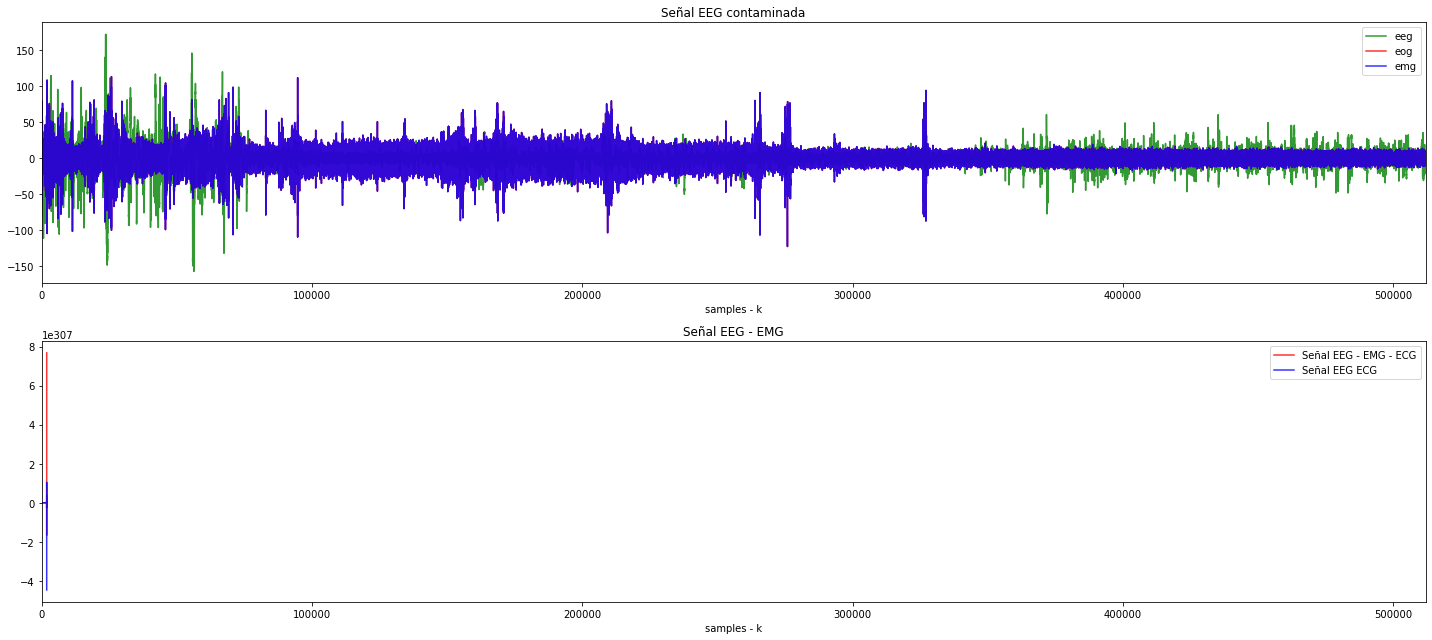

In [579]:
plt.figure(figsize=(20,9))
plt.subplot(211);plt.title("Señal EEG contaminada"),plt.xlabel("samples - k"),plt.xlim((0,N))
plt.plot(d1,"g",alpha=0.8, label="eeg")
plt.plot(x1,"r", alpha=0.8,label="eog")
plt.plot(x2,"b",alpha=0.8, label="emg")
plt.legend(loc='best')
#plt.subplot(512);plt.title("Señal EOG");plt.xlabel("samples - k"),plt.xlim((0,10)),plt.xlim((0,N/2))
#plt.plot(x1,"r", label="eog")
#plt.subplot(513);plt.title("Señal EMG");plt.xlabel("samples - k"),plt.xlim((0,10)),plt.xlim((0,N/2))
#plt.plot(x2,"r", label="eog")
plt.subplot(212);plt.title("Señal EEG - EMG");plt.xlabel("samples - k"),plt.xlim((0,10)),plt.xlim((0,N))
plt.plot(e1,"r",alpha=0.8,  label="Señal EEG - EMG - ECG")
plt.plot(e2,"b", alpha=0.8, label="Señal EEG ECG")
#plt.plot(e3,"g", alpha=0.8, label="Señal EEG filtrada")
plt.legend(loc='best')
#plt.subplot(515);plt.title("Señal EEG filtrada");plt.xlabel("samples - k"),plt.xlim((0,10)),plt.xlim((0,N/2))
#plt.plot(e,"b", label="error")
plt.tight_layout()
plt.show()


In [410]:
eeg_emg_f, eeg_emg_psd = signal.welch(e1, fs=fs, window='bartlett', nfft=256)
eeg_filtr_f, eeg_filtr_psd = signal.welch(e2, fs=fs, window='bartlett', nfft=256)

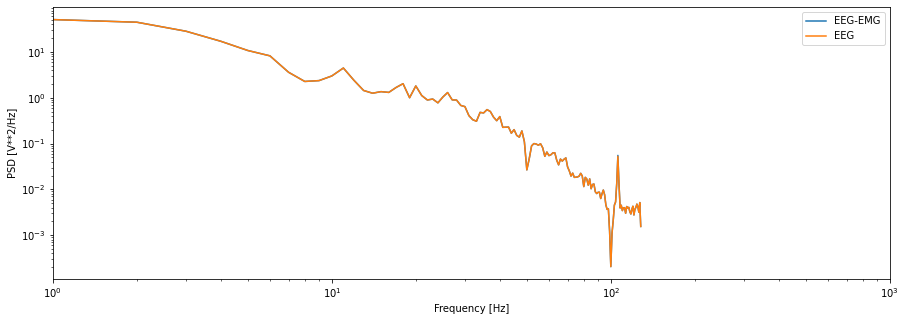

In [580]:
plt.figure(3).set_size_inches(15,5)

plt.loglog(eeg_emg_f, eeg_emg_psd, eeg_filtr_f, eeg_filtr_psd)
plt.legend(['EEG-EMG','EEG'])

plt.xlabel('Frequency [Hz]')
plt.xlim([1,1000])

plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [94]:

N = fs*s
t = np.arange(N)
#M = 10000

x1 = eog                 # Reference Data: EOG
x1_M = data_tap(x1, M)
d1 = eeg                 # Primary EEG

In [95]:
print(d1.shape)
print(x1_M.shape)
print(x1_M)
np.isnan(np.min(e1))

(10240,)
(10240, 128)
[[ 28.96970238   0.           0.         ...   0.           0.
    0.        ]
 [ 19.93384158  28.96970238   0.         ...   0.           0.
    0.        ]
 [  8.21164377  19.93384158  28.96970238 ...   0.           0.
    0.        ]
 ...
 [-56.50465659 -54.48990385 -51.77304029 ...  94.75443223 102.29449176
  110.07876374]
 [-58.27519689 -56.50465659 -54.48990385 ...  87.27542582  94.75443223
  102.29449176]
 [-60.32047619 -58.27519689 -56.50465659 ...  79.33852106  87.27542582
   94.75443223]]


True

In [96]:
f1 = pa.filters.FilterLMS(n = M, mu = .001, w='zeros')
y1, e1, w1 = f1.run(d1,x1_M)

print(x1.shape)
print(d1.shape)
print(e1.shape)

plt.figure(figsize=(15,9))
plt.subplot(311);plt.title("Señal EOG");plt.xlabel("samples - k")
plt.plot(x1,"r", label="eog")
plt.subplot(312);plt.title("Señal EEG contaminada");plt.xlabel("samples - k")
plt.plot(d1,"g", label="eeg")
plt.subplot(313);plt.title("Señal EEG - EMG");plt.xlabel("samples - k")
plt.plot(e1,"b", label="error")
plt.tight_layout()
plt.show()

C:\Users\germa\anaconda3\lib\site-packages\padasip\filters\base_filter.py:210: RuntimeWarning: invalid value encountered in add
  self.w += self.learning_rule(e[k], x[k])


(10240,)
(10240,)
(10240,)


C:\Users\germa\anaconda3\lib\site-packages\matplotlib\ticker.py:2072: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
C:\Users\germa\anaconda3\lib\site-packages\matplotlib\ticker.py:2104: RuntimeWarning: overflow encountered in double_scalars
  high = edge.ge(_vmax - best_vmin)
C:\Users\germa\anaconda3\lib\site-packages\matplotlib\ticker.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  d, m = divmod(x, self.step)


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

In [75]:
x2 = emg                 # Reference Data: EMG
x2_M = data_tap(x2, M)
d2 = e1   
print(d2.shape)
print(x2_M.shape)

(10240,)
(10240, 128)


C:\Users\germa\anaconda3\lib\site-packages\padasip\filters\base_filter.py:209: RuntimeWarning: overflow encountered in double_scalars
  e[k] = d[k] - y[k]
C:\Users\germa\anaconda3\lib\site-packages\padasip\filters\base_filter.py:210: RuntimeWarning: invalid value encountered in add
  self.w += self.learning_rule(e[k], x[k])


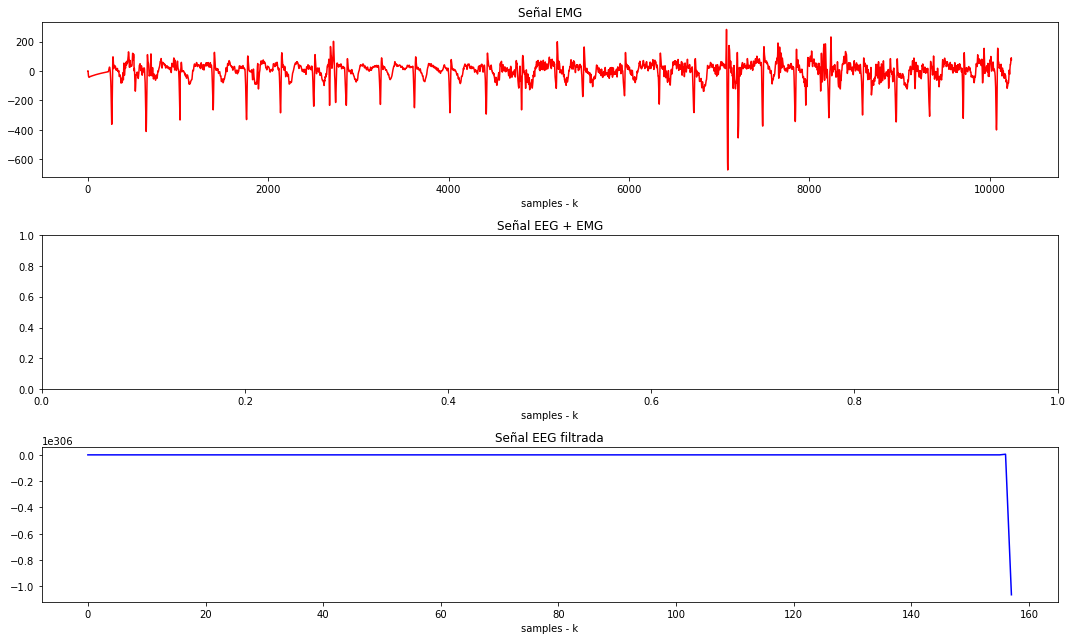

In [80]:
f2 = pa.filters.FilterLMS(n = M, mu = .001, w='zeros')
y, e, w = f2.run(d2,x2_M)

plt.figure(figsize=(15,9))
plt.subplot(311);plt.title("Señal EMG");plt.xlabel("samples - k")
plt.plot(x2,"r", label="eog")
plt.subplot(312);plt.title("Señal EEG + EMG");plt.xlabel("samples - k")
#plt.plot(d2,"g", label="eeg")
plt.subplot(313);plt.title("Señal EEG filtrada");plt.xlabel("samples - k")
plt.plot(e,"b", label="error")
plt.tight_layout()
plt.show()

In [ ]:
def plot_w(w, M):
  figure, axes = plt.subplots(nrows=M, figsize=(15,10))
  for i in range(M):
    axes[i].plot(w[:,i])
  plt.show()

In [ ]:
figure, axes = plt.subplots(nrows = 3, figsize=(15,10))
axes[0].plot(t, x), axes[0].set_title('EOG')
axes[1].plot(t, y), axes[1].set_title('EEG + EOG')
axes[2].plot(t, e), axes[2].set_title('EEG estimado')
plt.show()

# Análisis